In [144]:
# Import important libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier, XGBRegressor
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, mean_squared_error, r2_score
import shap
from scipy import sparse
import joblib

## Load and prepare data

In [126]:
# Load data
data = pd.read_csv("../data/raw/MachineLearningRating_v3.txt", sep="|", low_memory=False)

In [127]:
# prepare the data
# Create target variables
data["HasClaim"] = (data["TotalClaims"] > 0).astype(int)

#  Drop unnecessary columns
drop_cols = ['UnderwrittenCoverID', 'PolicyID', 'Bank', 'Country', 'NumberOfVehiclesInFleet']
data = data.drop(columns=drop_cols, errors='ignore')

# Convert datetime columns
for date_col in ["TransactionMonth", "VehicleIntroDate"]:
    if date_col in data.columns:
        data[date_col] = pd.to_datetime(data[date_col], errors="coerce", format='mixed')
        data[date_col] = (data[date_col] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Clean data
data.replace([np.inf, -np.inf], np.nan, inplace=True)

## DEFINE FEATURES AND TARGETS

In [128]:
## Features matrix (exclude target variables)
X = data.drop(columns=["TotalClaims", "HasClaim"])
# Target for classification model (claim occurrence)
y_class = data["HasClaim"]
# Target for regression model (claim amount)
y_reg = data["TotalClaims"]

## IDENTIFY FEATURE TYPES

In [129]:
# Get categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Filter out completely missing columns
categorical_cols = [col for col in categorical_cols if not data[col].isnull().all()]
numerical_cols = [col for col in numerical_cols if not data[col].isnull().all()]

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Categorical columns: ['Citizenship', 'LegalType', 'Title', 'Language', 'AccountType', 'MaritalStatus', 'Gender', 'Province', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'VehicleType', 'make', 'Model', 'bodytype', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'TermFrequency', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType']
Numerical columns: ['TransactionMonth', 'PostalCode', 'mmcode', 'RegistrationYear', 'Cylinders', 'cubiccapacity', 'kilowatts', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'SumInsured', 'CalculatedPremiumPerTerm', 'TotalPremium']


## CREATE PREPROCESSING PIPELINE

In [130]:
# ColumnTransformer handles different preprocessing for different feature types
preprocessor = ColumnTransformer(
    transformers=[
        # Numerical transformer
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median'))
        ]), numerical_cols),
        
        # Categorical transformer
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
        ]), categorical_cols)
    ],
    remainder='drop',
    sparse_threshold=1.0  # Always return sparse matrix
)


## CLASSIFICATION DATA SPLIT AND PREPROCESSING

In [131]:
# Split data into training and test sets for classification
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)
#  Preprocess classification data (keep sparse)
print("Preprocessing classification data...")
X_train_c_pre = preprocessor.fit_transform(X_train_c)
X_test_c_pre = preprocessor.transform(X_test_c)

Preprocessing classification data...


# REGRESSION DATA PREPARATION

In [132]:
# Filter only records with claims for regression modeling
claimed_data = data[data["HasClaim"] == 1]
X_reg = claimed_data.drop(columns=["TotalClaims", "HasClaim"])
y_reg = claimed_data["TotalClaims"]

print(f"Regression data size: {X_reg.shape[0]} claims")

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)
# Preprocess regression data (keep sparse)
print("Preprocessing regression data...")
X_train_r_pre = preprocessor.transform(X_train_r)
X_test_r_pre = preprocessor.transform(X_test_r)

Regression data size: 2788 claims
Preprocessing regression data...


# Model 1: Claim Occurrence (Classification)

In [133]:
print("\nTraining Claim Occurrence Model...")

# Balance the training set using SMOTE (handle sparse input)
smote = SMOTE(random_state=42)
X_train_c_bal, y_train_c_bal = smote.fit_resample(X_train_c_pre, y_train_c)

xgb_clf = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=len(y_train_c_bal[y_train_c_bal==0])/len(y_train_c_bal[y_train_c_bal==1]),
    tree_method='hist',  # More memory efficient
    random_state=42
)
xgb_clf.fit(X_train_c_bal, y_train_c_bal)

# Predictions and Evaluation
y_pred_c = xgb_clf.predict(X_test_c_pre)
print("\nClassification Report:")
print(classification_report(y_test_c, y_pred_c, zero_division=0))

# Handle class imbalance by adjusting decision threshold
y_probs = xgb_clf.predict_proba(X_test_c_pre)[:, 1]
y_pred_adj = (y_probs > 0.3).astype(int)  # Lower threshold for positive class
print("\nAdjusted Classification Report (threshold=0.3):")
print(classification_report(y_test_c, y_pred_adj, zero_division=0))


Training Claim Occurrence Model...

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199439
           1       0.04      0.06      0.05       581

    accuracy                           0.99    200020
   macro avg       0.52      0.53      0.52    200020
weighted avg       0.99      0.99      0.99    200020


Adjusted Classification Report (threshold=0.3):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    199439
           1       0.03      0.18      0.05       581

    accuracy                           0.98    200020
   macro avg       0.51      0.58      0.52    200020
weighted avg       0.99      0.98      0.99    200020



# Model 2: Claim Severity (Regression)

In [134]:
print("\nTraining Claim Severity Model...")
xgb_reg = XGBRegressor(
    random_state=42,
    tree_method='hist'  # More memory efficient
)
xgb_reg.fit(X_train_r_pre, y_train_r)

# Predictions and Evaluation
y_pred_r = xgb_reg.predict(X_test_r_pre)
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
r2 = r2_score(y_test_r, y_pred_r)
print(f"\nRMSE for claim severity: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")


Training Claim Severity Model...

RMSE for claim severity: 37878.23
R-squared: 0.11


## Feature Importance with SHAP


Generating SHAP explanations...

SHAP for Classification Model:


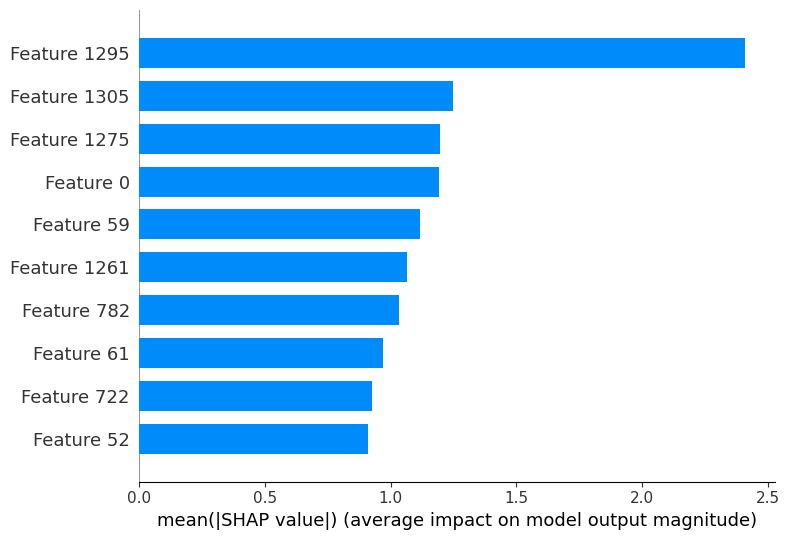

In [135]:
print("\nGenerating SHAP explanations...")

# For classification model
print("\nSHAP for Classification Model:")
# Use smaller sample for SHAP to save memory
sample_idx = np.random.choice(X_test_c_pre.shape[0], 1000, replace=False)
X_test_c_sample = X_test_c_pre[sample_idx].toarray() if sparse.issparse(X_test_c_pre) else X_test_c_pre[sample_idx]

explainer_c = shap.TreeExplainer(xgb_clf)
shap_values_c = explainer_c.shap_values(X_test_c_sample)
shap.summary_plot(shap_values_c, X_test_c_sample, plot_type="bar", max_display=10)


SHAP for Regression Model:


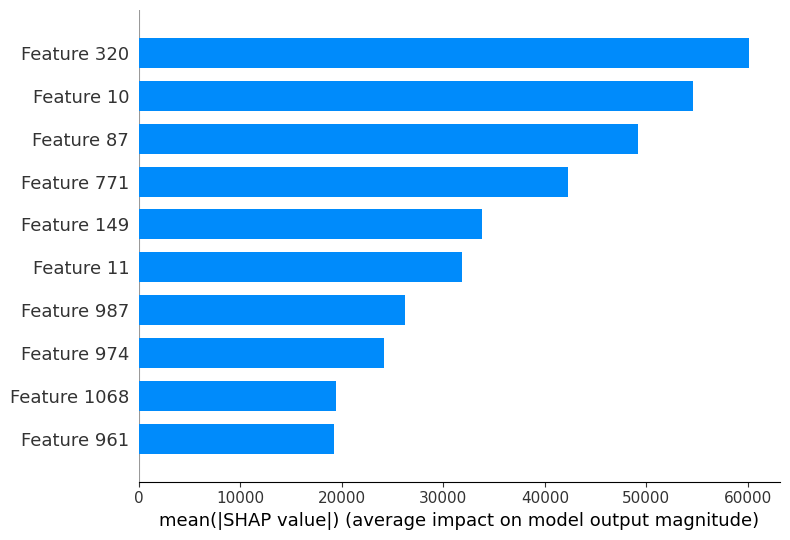

In [137]:
# For regression model
print("\nSHAP for Regression Model:")
# Use smaller sample for SHAP to save memory
sample_idx_r = np.random.choice(X_test_r_pre.shape[0], min(500, X_test_r_pre.shape[0]), replace=False)
X_test_r_sample = X_test_r_pre[sample_idx_r].toarray() if sparse.issparse(X_test_r_pre) else X_test_r_pre[sample_idx_r]

explainer_r = shap.TreeExplainer(xgb_reg)
shap_values_r = explainer_r.shap_values(X_test_r_sample)
shap.summary_plot(shap_values_r, X_test_r_sample, plot_type="bar", max_display=10)


# SAVE MODELS AND PREPROCESSOR

In [142]:
import os 
# Create directory for models if it doesn't exist
os.makedirs("../models", exist_ok=True)

In [145]:
# Save classification model
joblib.dump(xgb_clf, "../models/claim_occurrence_model.pkl")
print("\nSaved claim occurrence model to models/claim_occurrence_model.pkl")


Saved claim occurrence model to models/claim_occurrence_model.pkl


In [146]:
# Save regression model
joblib.dump(xgb_reg, "../models/claim_severity_model.pkl")
print("Saved claim severity model to models/claim_severity_model.pkl")

Saved claim severity model to models/claim_severity_model.pkl


In [147]:
# Save preprocessor for future use
joblib.dump(preprocessor, "../models/preprocessor.pkl")
print("Saved preprocessor to models/preprocessor.pkl")

Saved preprocessor to models/preprocessor.pkl
